In [1]:
# SpaceTransformer Example: Medical Image Processing
# This notebook demonstrates the power of SpaceTransformer for medical image coordinate transformations

import pydicom
from spacetransformer import Space, warp_point
from spacetransformer.torch import warp_image
from matplotlib import pyplot as plt
import numpy as np
import os

In [2]:
ds = pydicom.dcmread('./sample_1/I50')
img = ds.pixel_array[None] + np.float32(ds.RescaleIntercept)
space = Space(shape=(ds.Rows, ds.Columns, 1), 
              spacing=(ds.PixelSpacing[0],ds.PixelSpacing[1], ds.SliceThickness),
              origin=ds.ImagePositionPatient,
              x_orientation=ds.ImageOrientationPatient[0:3],
              y_orientation=ds.ImageOrientationPatient[3:6],
              z_orientation=np.cross(ds.ImageOrientationPatient[0:3], ds.ImageOrientationPatient[3:6]))
space = space.reverse_axis_order() # numpy axis order is different from dicom

def get_aorta_bbox():
    return [[0,1], [200, 400],[140,280]]


def get_aorta_segmentation_and_contour(img):
    def binary_to_contour_points(arr):
        arr = arr.astype(bool)
        m = arr.copy()
        m[1:-1,1:-1] &= ~(arr[0:-2,1:-1] & arr[2:,1:-1] & arr[1:-1,0:-2] & arr[1:-1,2:])
        pts = np.argwhere(m)
        h, w = arr.shape
        return pts[(pts[:,0] > 0) & (pts[:,0] < h-1) & (pts[:,1] > 0) & (pts[:,1] < w-1)]

    def coord_2d_to_3d(x):
        x_3d = np.zeros([len(x),3])
        x_3d[:, 1:] = x
        return x_3d
    
    mask = img>200
    contour = binary_to_contour_points(mask[0])
    contour_3d = coord_2d_to_3d(contour)
    return mask, contour_3d


### let's take the center point of aorta as example

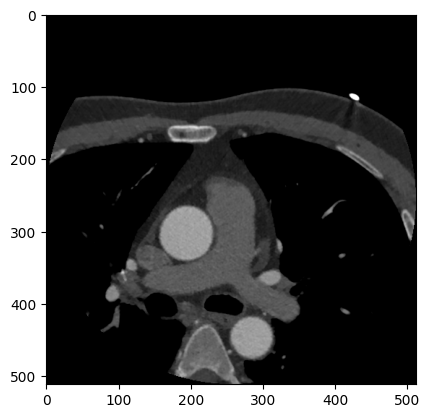

In [3]:
plt.figure()
plt.imshow(img[0], vmin=-200, vmax=700, cmap='gray')
plt.show()

### run segmentation and point detection at cropped space

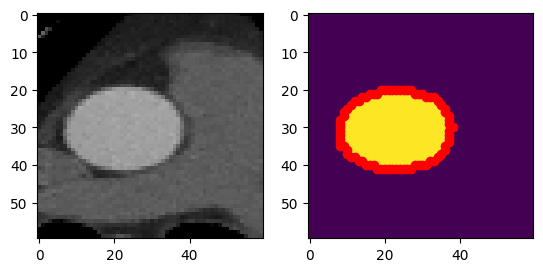

<Figure size 640x480 with 0 Axes>

In [4]:
bbox = get_aorta_bbox()
target_shape = [1, 60,60]
crop_space = space.apply_bbox(bbox).apply_shape(target_shape)
crop_image = warp_image(img, space, crop_space, mode='trilinear', pad_mode='constant', pad_value=0)
mask, contour = get_aorta_segmentation_and_contour(crop_image)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(crop_image[0], vmin=-200, vmax=700, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(mask[0])
plt.scatter(contour[:,2], contour[:,1], c='r')
plt.show()


###  Easily get back the result in original space

In [5]:
# warp_back_mask = _trans_general(torch.from_numpy(mask[None,None,None]), crop_space, space, mode='nearest', pad_mode='constant', pad_value=0)[0,0].cpu().numpy()

warp_back_mask = warp_image(mask, crop_space, space, mode='nearest', pad_mode='constant', pad_value=0)
warp_back_point = warp_point(contour, crop_space, space)[0]

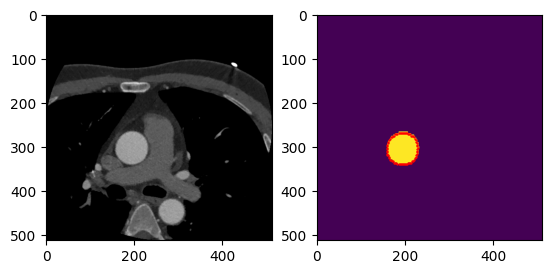

In [8]:
fig = plt.figure()
plt.subplot(1,2,1)
plt.imshow(img[0], vmin=-200, vmax=700, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(warp_back_mask[0])
plt.scatter(warp_back_point[:,2], warp_back_point[:,1], c='r',s=0.4)
plt.show()


### Easily bridge the gap between any space and world coordinate

In [7]:
### let's take the center point of aorta as example
center_point_world = crop_space.to_world_transform(contour.mean(axis=0))[0]
print('center point of aorta in world space:')
print(center_point_world.round(2))

center point of aorta in world space:
[ -18.83   99.19 1369.95]


Let's confirm the result in PACS viewer:

<img src="show_point.png" alt="alternative text" width="800">
